# Introduction #

In the tutorial, we saw how to build an image classifier by attaching a head of dense layers to a pretrained base. The base we used was from a model called **VGG16**. We saw that the VGG16 architecture was prone to overfitting this dataset. Over this course, you'll learn a number of ways you can improve upon this initial attempt.

The first way you'll see is to use a base more appropriate to the dataset. The base this model comes from is called **InceptionV1** (also known as GoogLeNet). InceptionV1 was one of the early winners of the ImageNet competition. One of its successors, InceptionV4, is among the state of the art today.

To get started, run the code cell below to set everything up.

## 数据目录

**car-or-truck<br>**
**--train<br>**
----Car<br>
------1.jpg<br>
------2.jpg<br>
----Truck<br>
------3.jpg<br>
------4.jpg<br>
**--vaild<br>**
----Car<br>
------5.jpg<br>
------6.jpg<br>
----Truck<br>
------7.jpg<br>
------8.jpg<br> 

In [9]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex1 import *

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


The **InceptionV1** model pretrained on ImageNet is available in the [TensorFlow Hub](https://www.tensorflow.org/hub/) repository, but we'll load it from a local copy. Run this cell to load InceptionV1 for your base.

In [10]:
import tensorflow_hub as hub

# 在线下载
# pretrained_base = tf.keras.models.load_model(
#     '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
# )

# 从本地加载
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/inceptionv1'
)

# 1) Define Pretrained Base #

Now that you have a pretrained base to do our feature extraction, decide whether this base should be trainable or not.

In [11]:
# YOUR_CODE_HERE
pretrained_base.trainable = False

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> When doing transfer learning, it's generally not a good idea to retrain the entire base -- at least not without some care. The reason is that the random weights in the head will initially create large gradient updates, which propogate back into the base layers and destroy much of the pretraining. Using techniques known as **fine tuning** it's possible to further train the base on new data, but this requires some care to do well.

# 2) Attach Head #

Now that the base is defined to do the feature extraction, create a head of `Dense` layers to perform the classification, following this diagram:

<figure>
<img src="https://i.imgur.com/i5VU7Ry.png" alt="Diagram of the dense head.">
</figure>


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    # YOUR CODE HERE. Attach a head of dense layers.
    layers.Dense(6,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

# 3) Train #

Before training a model in Keras, you need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a **binary classification** problem: `Car` coded as 0, and `Truck` coded as 1. Choose an appropriate loss and an appropriate accuracy metric for binary classification.

In [13]:
# YOUR CODE HERE: what loss function should you use for a binary
# classification problem? (Your answer for each should be a string.)
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [14]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
#     epochs=30,
    epochs=1,
)

80/80 [==============================] - 114s 1s/step - loss: 0.7006 - binary_accuracy: 0.5419 - val_loss: 0.6893 - val_binary_accuracy: 0.6003


Run the cell below to plot the loss and metric curves for this training run.

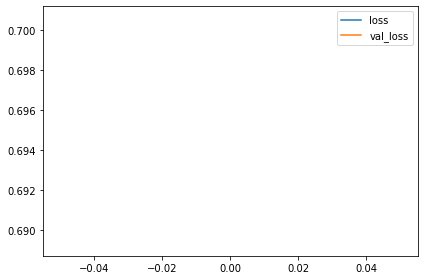

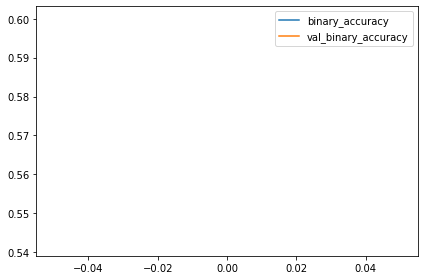

In [15]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# 4) Examine Loss and Accuracy #

Do you notice a difference between these learning curves and the curves for VGG16 from the tutorial? What does this difference tell you about what this model (InceptionV2) learned compared to VGG16? Are there ways in which one is better than the other? Worse?

After you've thought about it, run the cell below to see the answer.

In [16]:
# View the solution (Run this code cell to receive credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

That the training loss and validation loss stay fairly close is evidence that the model isn't just memorizing the training data, but rather learning general properties of the two classes. But, because this model converges at a loss greater than the VGG16 model, it's likely that it is underfitting some, and could benefit from some extra capacity.


# Conclusion #

In this first lesson, you learned the basics of **convolutional image classifiers**, that they consist of a **base** for extracting features from images, and a **head** which uses the features to decide the image's class. You also saw how to build a classifier with **transfer learning** on pretrained base. 